In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(patchwork)
    library(nloptr)
    library(adoptr)
    library(future)
    plan(multisession)
})

source("util.R")

dir.create("figures", showWarnings = FALSE)

# restore optimal two-stage design and corresponding
# Lagrange multiplier
optimal_design <- read_rds("optimal_design.RDS")
        lambda <- read_rds("lambda.RDS")

options(repr.plot.width = 12, repr.plot.height = 5)

In [2]:
prior <- TruncatedNormal(mu = 0.4, tau = 0.2, a = -0.5, b = 1.0)

n_max <- 160
    m <- 35

critical_value <- function(design, zm) {
     n =  n(design, zm)
    n1 = n1(design)
    c2 = c2(design, zm)
    if (!is.finite(c2)) return(c2)
    sqrt(n - n1) / sqrt(n) * c2 + sqrt(n1/n) * zm
}

In [3]:
priormean <- 0.4; zm <- 0.3*sqrt(m)
n_old <- n(optimal_design, zm, round = FALSE)
c_old <- critical_value(optimal_design, zm)

print(c(n_old, c_old))

[1] 84.201946  2.047879


In [4]:
alpha_bar <- conditional_power(zm, m, n_old, c_old, 0)
new_prior <- TruncatedNormal(priormean, 0.2, -0.5, 1.0)
objective <- function(x) {
    n_bar <- x[1]; c_bar <- x[2]
    n_bar - lambda*predictive_power(zm, m = m, n = n_bar, c = c_bar, prior = new_prior)
}
conditional_error_constraint <- function(x) {
    n_bar <- x[1]; c_bar <- x[2]
    conditional_power(zm, m = m, n = n_bar, c = c_bar, theta = 0) - alpha_bar # <= 0
}

In [5]:
res <- nloptr::nloptr(
             x0 = c(n_old, c_old), 
         eval_f = objective, 
    eval_g_ineq = conditional_error_constraint, 
             lb = c(m, 0), 
             ub = c(n_max, 5),
    opts = list(
        algorithm = "NLOPT_LN_COBYLA",
         xtol_rel = 1e-6
    )
)


In [6]:
# adapt at original interim analysis
adapt <- function(priormean, zm) {
    n_old <- n(optimal_design, zm, round = FALSE)
    c_old <- critical_value(optimal_design, zm)
    if (!is.finite(c_old)) 
        return(list(
            n = n_old,
            c = c_old,
            optim = NULL
        ))
    # old conditional type-I error
    alpha_bar <- conditional_power(zm, m, n_old, c_old, 0)
    new_prior <- TruncatedNormal(priormean, 0.2, -0.5, 1.0)
    objective <- function(x) {
        n_bar <- x[1]; c_bar <- x[2]
        n_bar - lambda*predictive_power(zm, m = m, n = n_bar, c = c_bar, prior = new_prior)
    }
    conditional_error_constraint <- function(x) {
        n_bar <- x[1]; c_bar <- x[2]
        conditional_power(zm, m = m, n = n_bar, c = c_bar, theta = 0) - alpha_bar # <= 0
    }
    res <- nloptr::nloptr(
                 x0 = c(n_old, c_old), 
             eval_f = objective, 
        eval_g_ineq = conditional_error_constraint, 
                 lb = c(m, 0), 
                 ub = c(n_max, 5),
        opts = list(
            algorithm = "NLOPT_LN_COBYLA",
             xtol_rel = 1e-4,
              maxeval = 1e5
        )
    )
    if (res$status != 4) stop(res$message)
    n_bar <- if (round(res$solution[1]) >= n_max)   m else res$solution[1]
    c_bar <- if (round(res$solution[1]) >= n_max) Inf else res$solution[2]
    n_bar <- if (round(res$solution[1]) <= m)   m else res$solution[1]
    c_bar <- if (round(res$solution[1]) <= m) Inf else res$solution[2]
    list(
            n = n_bar,
            c = c_bar,
        optim = res
    )
}

In [14]:
thetas <- seq(0.3, 0.4, by = 0.05)

tbl_adapted <- expand_grid(
            zm = sqrt(m)*thetas,
    `new mean` = seq(-0.5, 1, length.out = 100)
) %>%
mutate(
    tmp = map2(`new mean`, zm, ~{tmp <- adapt(..1, ..2); tibble(n = tmp$n, c = tmp$c)})
) %>%
unnest(tmp) %>%
mutate(
    section = if_else(c == Inf, "early futility", "continue"),
     effect = factor(zm/sqrt(m)),
         PP = pmap_dbl(
             list(zm, n, c, `new mean`), 
             ~predictive_power(zm = ..1, m = m, n = ..2, c = ..3, prior = TruncatedNormal(..4, 0.2, -0.5, 1.0))
         )
)

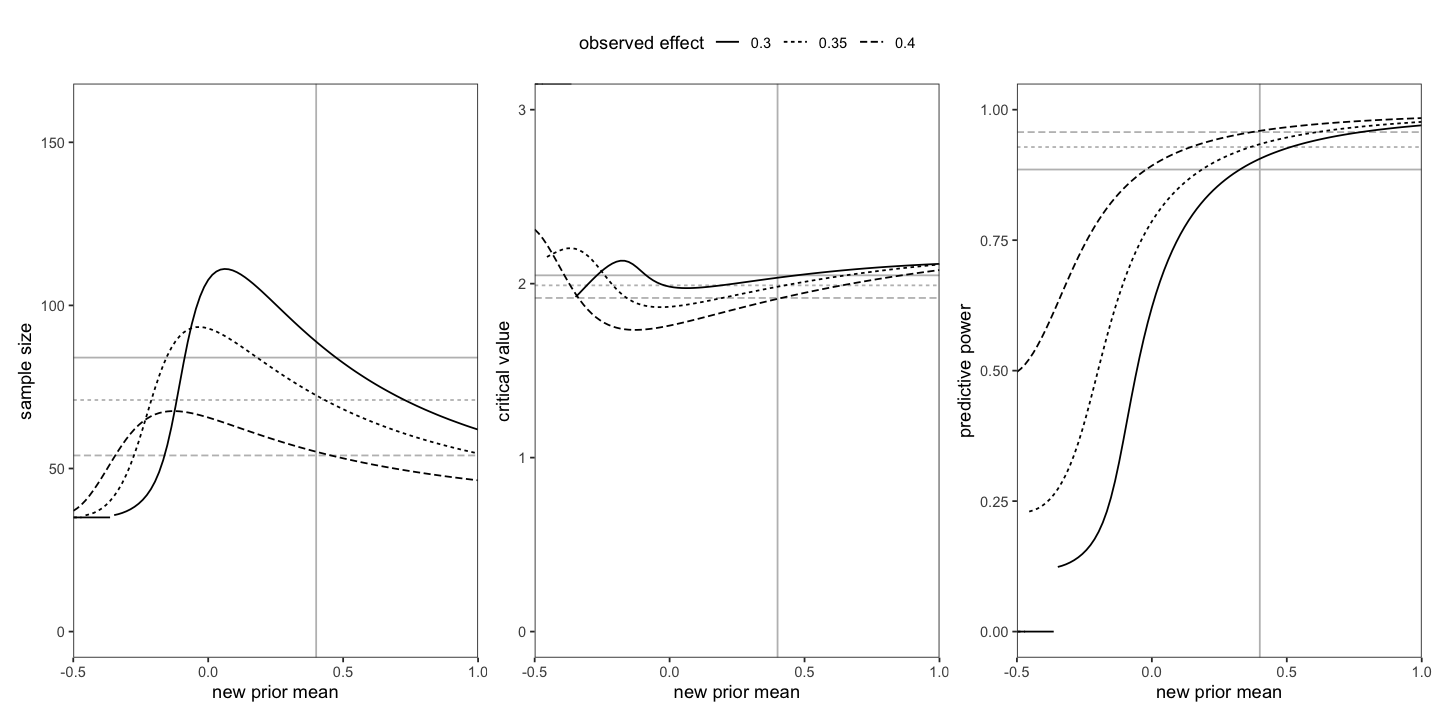

In [15]:
options(repr.plot.width = 12, repr.plot.height = 6)

tbl_original <- tibble(
    effect = thetas,
         n = map_dbl(effect, ~n(optimal_design, sqrt(m)*.)),
         c = map_dbl(effect, ~critical_value(optimal_design, sqrt(m)*.)),
        PP = pmap_dbl(
            list(effect, n, c), 
            ~predictive_power(sqrt(m)*., m = m, n = ..2, c = ..3, prior = prior)
        )
) %>% 
mutate(
    effect = factor(effect)
)

plt1 <- ggplot(tbl_adapted) +
    aes(`new mean`, n, group = interaction(section, effect)) +
    geom_hline(aes(yintercept = n, linetype = effect), color = "grey", data = tbl_original) + 
    geom_vline(xintercept = 0.4, color = "grey") + 
    geom_line(aes(linetype = effect)) +
    scale_x_continuous('new prior mean', expand = c(0, 0)) +
    scale_y_continuous('sample size', limits = c(0, n_max)) +
    scale_linetype('observed effect') +
    theme_bw() + 
    theme(
        legend.position = 'top',
        panel.grid = element_blank()
    )

plt2 <- ggplot(tbl_adapted) +
    aes(`new mean`, c, group = interaction(section, effect)) +
    geom_hline(aes(yintercept = c, linetype = effect), color = "grey", data = tbl_original) + 
    geom_vline(xintercept = 0.4, color = "grey") + 
    geom_line(aes(linetype = effect)) +
    scale_x_continuous('new prior mean', expand = c(0, 0)) +
    scale_y_continuous('critical value', limits = c(0, 3)) +
    scale_linetype('observed effect') +
    theme_bw() + 
    theme(
        legend.position = 'top',
        panel.grid = element_blank()
    )

plt3 <- ggplot(tbl_adapted) +
    aes(`new mean`, PP, group = interaction(section, effect)) +
    geom_hline(aes(yintercept = PP, linetype = effect), color = "grey", data = tbl_original) + 
    geom_vline(xintercept = 0.4, color = "grey") + 
    geom_line(aes(linetype = effect)) +
    scale_x_continuous('new prior mean', expand = c(0, 0)) +
    scale_y_continuous('predictive power', limits = c(0, 1)) +
    scale_linetype('observed effect') +
    theme_bw() + 
    theme(
        legend.position = 'top',
        panel.grid = element_blank()
    )

plt1 + plt2 + plt3 + plot_layout(guides = "collect") & theme(legend.position = 'top')

In [18]:
ggsave("figures/recalculation-lambda-approach-original-m.pdf", width = 8, height = 3.5)